# Emitting surfaces

In [1]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_E, M_E
from POSEIDON.core import wl_grid_constant_R
from scipy.constants import parsec as pc


#***** Wavelength grid *****#
 
wl_min = 0.4      # Minimum wavelength (um)
wl_max = 14.0     # Maximum wavelength (um)
R = 1000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Define stellar properties *****#

R_s = 0.11697*R_Sun   # Stellar radius (m)
T_s = 2559.0          # Stellar effective temperature (K)
Met_s = 0.04          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 5.21        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl)

#***** Define planet properties *****#

planet_name = 'TRAPPIST-1e'  # Planet name used for plots, output files etc.

R_p = 0.917985*R_E     # Planetary radius (m)
M_p = 0.6356*M_E       # Planetary mass (kg)
T_eq = 255.0           # Equilibrium temperature (K)
d = 12.1 * pc

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, T_eq = T_eq)

In [2]:
from POSEIDON.core import define_model
import numpy as np

#***** Define models *****#

model_name_1 = 'Test'   # First model

bulk_species = ['N2']                                      # For terrestrial planets, only the single most abundant gas should be provided here
param_species = []   

# Create the model objects
model_1 = define_model(model_name_1, bulk_species, param_species, 
                       PT_profile = 'isotherm',
                       radius_unit = 'R_E', surface = True,
                       scattering = True,
                       surface_model = 'constant',
                       surface_temp = True)

surface_components = ['Alkaline_basalt_small','Lunar_mare_basalt']

model_2 = define_model(model_name_1, bulk_species, param_species, 
                       PT_profile = 'isotherm',
                       radius_unit = 'R_E', surface = True,
                       scattering = True,
                       surface_model = 'lab_data',
                       surface_temp = True,
                       surface_components = surface_components)


model_boring = define_model(model_name_1, bulk_species, param_species, 
                       PT_profile = 'isotherm',
                       radius_unit = 'R_E', surface = True,
                       scattering = True)

#***** Create model pressure grid (same for both models) *****#

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 10.0      # 10 bar (you can extend the atmosphere deeper than the surface)
N_layers = 100    # 100 layers

P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Add the surface pressure
P_surf = 1.0      # Effectively acts as a cloud deck opaque at all wavelengths

# Specify the reference pressure and radius
P_ref = P_surf    # We'll set the reference pressure at the surface
R_p_ref = R_p     # Radius at reference pressure

print(model_boring['param_names'])
print(model_1['param_names'])
print(model_2['param_names'])

['R_p_ref' 'T' 'log_P_surf']
['R_p_ref' 'T' 'log_P_surf' 'T_surf' 'albedo_surf']
['R_p_ref' 'T' 'log_P_surf' 'T_surf' 'Alkaline_basalt_small_percentage'
 'Lunar_mare_basalt_percentage']


#### Creating the model atmosphere

We can now provide the temperature and mixing ratio profiles to the usual function to generate our two atmospheres.

In [20]:
from POSEIDON.core import make_atmosphere
from POSEIDON.visuals import plot_geometry, plot_PT, plot_chem

T = 300

log_P_surf = -6
surface_albedo = 0.25
T_surf = 600

Alkaline_basalt_small_percentage = 0.25
Lunar_mare_basalt_percentage = 0.75

PT_params = np.array([T])
X_params = np.array([])
surface_params = np.array([log_P_surf, T_surf, surface_albedo,])

# Generate the atmospheres
atmosphere_1 = make_atmosphere(planet, model_1, P, P_ref, R_p_ref, 
                              PT_params, X_params,  surface_params = surface_params)         


T_surf = 600

surface_params = np.array([log_P_surf, T_surf, Alkaline_basalt_small_percentage, Lunar_mare_basalt_percentage])

atmosphere_2 = make_atmosphere(planet, model_2, P, P_ref, R_p_ref, 
                               PT_params, X_params,  surface_params = surface_params)    

surface_params = np.array([log_P_surf])

atmosphere_boring = make_atmosphere(planet, model_boring, P, P_ref, R_p_ref, 
                               PT_params, X_params,  surface_params = surface_params)    


print(atmosphere_1['P_surf'])
print(atmosphere_1['T_surf'])
print(atmosphere_1['albedo_surf'])
print(atmosphere_1['surface_component_percentages'])
print()
print(atmosphere_2['P_surf'])
print(atmosphere_2['T_surf'])
print(atmosphere_2['albedo_surf'])
print(atmosphere_2['surface_component_percentages'])

1e-06
600.0
0.25
0

1e-06
600.0
0
[0.25 0.75]


In [21]:
from POSEIDON.core import read_opacities, wl_grid_constant_R

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100     # 100 K lower limit covers the TRAPPIST-1e P-T profile
T_fine_max = 1500     # 300 K upper limit covers the TRAPPIST-1e P-T profile
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 0.0    # 1 bar is the surface pressure, so no need to go deeper
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Create opacity object (both models share the same molecules, so we only need one)
opac = read_opacities(model_1, wl, opacity_treatment, T_fine, log_P_fine,
                      opacity_database = 'Temperate')

Reading in cross sections in opacity sampling mode...
N2-N2 done
Opacity pre-interpolation complete.


#### Comparing TRAPPIST-1e model spectra

Finally, let's generate and compare the Modern Earth and Archean Earth transmission spectra.

In [22]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate our first transmission spectrum
spectrum_const = compute_spectrum(planet, star, model_1, atmosphere_1, opac, wl,
                                   spectrum_type = 'emission')

spectrum_lab_data = compute_spectrum(planet, star, model_2, atmosphere_2, opac, wl,
                                   spectrum_type = 'emission')

spectrum_boring = compute_spectrum(planet, star, model_boring, atmosphere_boring, opac, wl,
                                   spectrum_type = 'emission')

[2.52524102e-10 2.66785934e-10 2.81836340e-10 ... 1.15485555e+08
 1.15150047e+08 1.14815363e+08]
[9.21881323e-11 9.72209101e-11 1.02521784e-10 ... 1.09418714e+08
 1.09100831e+08 1.08783729e+08]
[1.72659146e-10 1.82228150e-10 1.92315568e-10 ... 1.23908302e+08
 1.23548323e+08 1.24061827e+08]
[3.10245719e-36 3.48015252e-36 3.90336082e-36 ... 2.34595087e+07
 2.34253997e+07 2.33912668e+07]


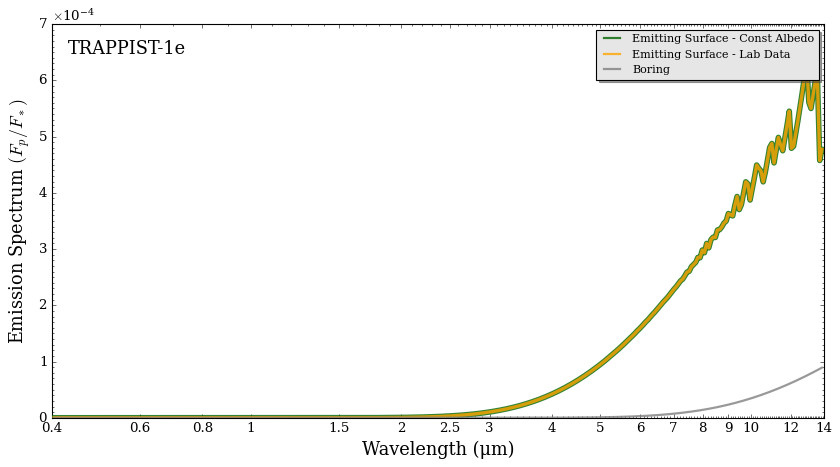

In [26]:
spectra = []   # Empty plot collection

# Add the two model spectra to the plot collection object
spectra = plot_collection(spectrum_const, wl, collection = spectra)
spectra = plot_collection(spectrum_lab_data, wl, collection = spectra)
spectra = plot_collection(spectrum_boring, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        spectra_labels = ['Emitting Surface - Const Albedo', 'Emitting Surface - Lab Data', 'Boring'],
                        colour_list = ['darkgreen', 'orange', 'gray'], 
                        line_widths = [5,3,2],
                        figure_shape = 'wide',
                        y_unit = 'eclipse_depth')   # Switch to a 'wide' format (16:9) for better viewing a long wavelength range

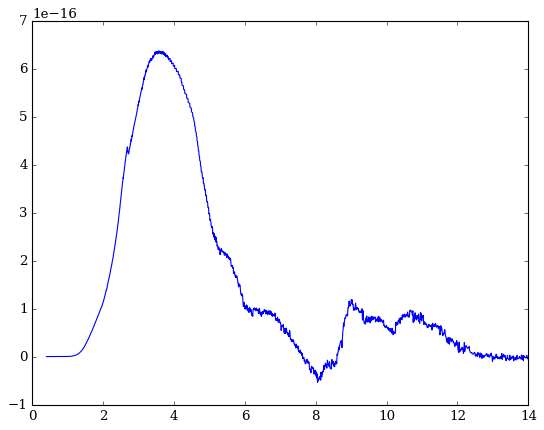

In [27]:
import matplotlib.pyplot as plt

plt.plot(wl,spectrum_const-spectrum_lab_data)